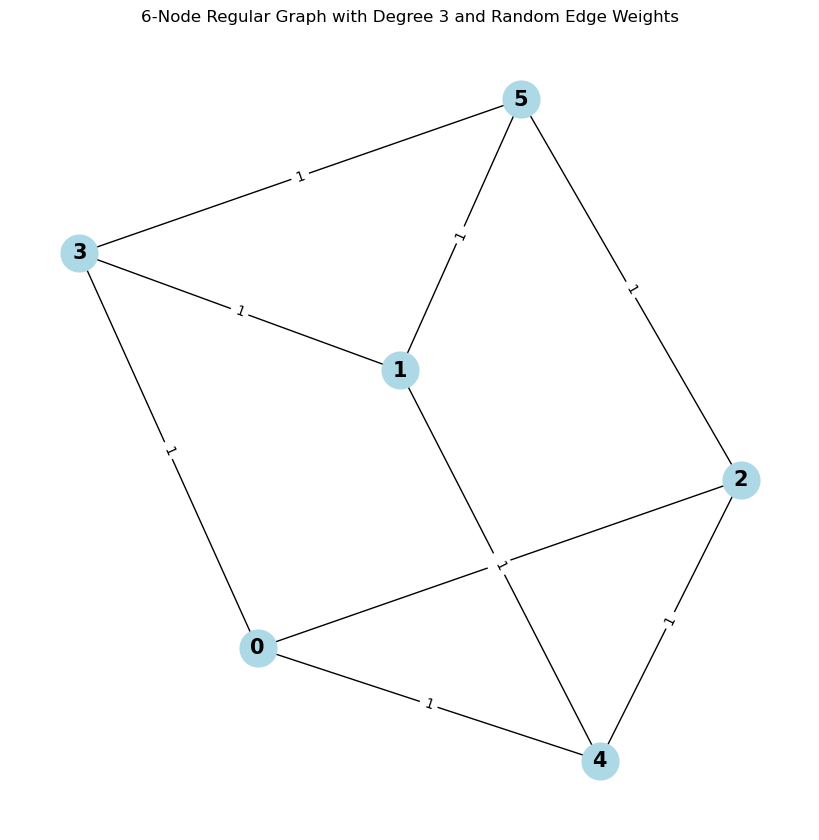

In [136]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter

# 生成一个度为 3 的正则图（6个顶点）
n = 6  # 顶点数
degree = 3  # 每个顶点的度数

# 创建正则图
G = nx.random_regular_graph(degree, n)

# # 为每条边分配一个随机的权重（在 [0, 1] 范围内）
# for u, v in G.edges():
#     G[u][v]['weight'] = np.random.uniform(0, 1)
for u, v in G.edges():
    G[u][v]['weight'] = 1

# 计算节点的位置（使用 spring_layout 或其他布局方法）
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置

# 绘制图形
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("6-Node Regular Graph with Degree 3 and Random Edge Weights")
plt.show()
N = G.number_of_nodes()

In [137]:
# def pauli_z_term(index, num_qubits):
#     """初始化一个 Pauli-I 门的列表,指定索引 index 替换为 Pauli-Z 门"""
#     paulis = ['I'] * num_qubits
#     paulis[index] = 'Z'
#     return ''.join(paulis)  # 将列表转化为字符串
def pauli_z_term(indices, num_qubits):
    """生成 Pauli-Z 项"""
    z_str = ['I'] * num_qubits
    for idx in indices:
        z_str[idx] = 'Z'
    return ''.join(z_str)


def pauli_x_term(index, num_qubits):
    paulis = ['I'] * num_qubits
    paulis[index] = 'X'
    return ''.join(paulis)

In [138]:
from qiskit.quantum_info import SparsePauliOp

# 初始化 Pauli 字符串和系数
pauli_strings = []
coefficients = []

# 构建最大割问题的哈密顿量
for u, v in G.edges():
    weight = G[u][v]['weight']

    # 创建 Pauli 字符串
    z_term = ['I'] * N  # 假设有 n 个量子比特
    z_term[u] = 'Z'  # 在节点 u 上应用 Pauli Z
    z_term[v] = 'Z'  # 在节点 v 上应用 Pauli Z

    # 将 Pauli 字符串加入列表
    pauli_strings.append(''.join(z_term))

    # 系数是边权重的一半
    coefficients.append(weight / 2)

# 转换为 SparsePauliOp 格式
hamiltonian = SparsePauliOp.from_list(list(zip(pauli_strings, coefficients)))

# 输出哈密顿量
print(hamiltonian)


SparsePauliOp(['IIZIZI', 'ZIZIII', 'IIZIIZ', 'ZIIIZI', 'IZIIZI', 'ZIIZII', 'IZIIIZ', 'IZIZII', 'IIIZIZ'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


In [139]:
def append_multi_rzz_term(qc, qubits, gamma):
    """
    构建一个类RZZ门，n-1个控制位，1个目标位，进行旋转操作。
    参数:
    control_qubits: List[int]，控制量子比特的索引
    target_qubit: int，目标量子比特的索引
    """
    if len(qubits) == 1:
        qc.rz(gamma, qubits[0])
    else:
        control_qubits = qubits[:N - 1]

        target_qubit = qubits[N - 1:]

        n_controls = len(control_qubits)
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])
        qc.rz(gamma, target_qubit[0])
        if n_controls == 1:
            qc.cx(control_qubits[0], target_qubit[0])
        else:
            qc.mcx(control_qubits, target_qubit[0])

In [140]:
def append__zz_term(qc, qubit1, qubit2, gamma):
    qc.cx(qubit1, qubit2)
    qc.rz(2 * gamma, qubit2)
    qc.cx(qubit1, qubit2)


def append__z_term(qc, qubit, gamma):
    qc.rz(2 * gamma, qubit)


def append__mixer_term(qc, qubit, beta):
    qc.rx(2 * beta, qubit)

In [141]:
def get_cost_circuit(gamma, qc):
    for i, j in G.edges():
        append__zz_term(qc, i, j, gamma)
    return qc

In [142]:
def get_mixer_operator_circuit(G, beta, qc):
    for i in G.nodes():
        append__mixer_term(qc, i, beta)
    return qc

混合池相关函数

In [143]:
from qiskit.quantum_info import Pauli
import numpy as np
from qiskit.opflow import PauliOp, StateFn

"""
1. 定义混合池算符
"""


def generate_mixer_pool_grouped():
    """
    生成一个候选池 mixer_pool for ADAPT-QAOA.
    每组包含所有 qubit 的单比特操作符（X、Y）或双比特操作符（XX、YY）。

    :param n_qubits: 量子比特数
    :return: mixer_pool，每个元素是一个 Pauli 对象的列表
    """
    mixer_pool = []

    # 单比特操作符分组

    x_group = [Pauli('I' * i + 'X' + 'I' * (N - 1 - i)) for i in range(N)]
    y_group = [Pauli('I' * i + 'Y' + 'I' * (N - 1 - i)) for i in range(N)]
    global_x = [Pauli('X' * N)]  # 新增全局 Y 操作符
    global_y = [Pauli('Y' * N)]  # 新增全局 Y 操作符
    # z_group = [Pauli('I' * i + 'Z' + 'I' * (N - 1 - i)) for i in range(N)]  # 新增 Z 操作符
    mixer_pool.append(x_group)  # 单比特 X 分组
    mixer_pool.append(y_group)  # 单比特 Y 分组
    mixer_pool.append(global_x)
    mixer_pool.append(global_y)
    # mixer_pool.append(z_group)  # 单比特 Z 分组
    # mixer_pool.append(h_group)  # 单比特 H 分组
    # 双比特操作符分组
    xx_group = []
    yy_group = []
    zz_group = []  # 新增 ZZ 操作符
    xy_group = []  # 新增 XY 操作符
    # yx_group = []  # 新增 YX 操作符
    for i in range(N):
        for j in range(i + 1, N):
            # 生成双比特 XX 和 YY 操作符
            xx_group.append(Pauli('I' * i + 'X' + 'I' * (j - i - 1) + 'X' + 'I' * (N - j - 1)))
            yy_group.append(Pauli('I' * i + 'Y' + 'I' * (j - i - 1) + 'Y' + 'I' * (N - j - 1)))
            zz_group.append(Pauli('I' * i + 'Z' + 'I' * (j - i - 1) + 'Z' + 'I' * (N - j - 1)))  # 新增 ZZ
            xy_group.append(Pauli('I' * i + 'X' + 'I' * (j - i - 1) + 'Y' + 'I' * (N - j - 1)))  # 新增 XY
            # yx_group.append(Pauli('I' * i + 'Y' + 'I' * (j - i - 1) + 'X' + 'I' * (num_qubits - j - 1)))  # 新增 YX
    mixer_pool.append(xx_group)  # 双比特 XX 分组
    mixer_pool.append(yy_group)  # 双比特 YY 分组
    mixer_pool.append(zz_group)  # 双比特 ZZ 分组
    mixer_pool.append(xy_group)  # 双比特 XY 分组
    return mixer_pool


"""
2. 根据选中的混合池算符，构建mixer线路
"""


def mixer_circuit(mixer_group, beta, qc):
    """
    根据选择的 mixer_group 构建 Mixer 量子线路。
    :param n_qubits: 量子比特数。
    :param mixer_group: 一个包含多个 Pauli 算符的组，或单个 Pauli。
    :param beta: 对应的参数 beta。
    :return: QuantumCircuit 对象。
    """
    # 如果输入是单个 Pauli，而不是组，将其转为列表处理
    if isinstance(mixer_group, Pauli):
        mixer_group = [mixer_group]

    # 遍历组内的每个 Pauli 算符
    for mixer in mixer_group:
        # print(mixer)
        for i, pauli in enumerate(mixer.to_label()):
            if pauli == 'X':
                qc.rx(2 * beta, i)
            elif pauli == 'Y':
                qc.ry(2 * beta, i)
            elif pauli == 'Z':
                qc.rz(2 * beta, i)

    return qc

计算梯度相关子函数

In [145]:
def merge_sparse_pauli_ops(A_list):
    """
    将一个包含多个 SparsePauliOp 的列表合并为一个 SparsePauliOp
    :param A_list: list of SparsePauliOp
    :return: SparsePauliOp
    """
    if not A_list:
        raise ValueError("A_list is empty.")
    # 合并所有 SparsePauliOp
    combined_sparse_pauli_op = A_list[0]
    for A in A_list[1:]:
        combined_sparse_pauli_op += A

    return combined_sparse_pauli_op


# 计算 [H_C, A] = H_C * Mixer - Mixer * H_C
def compute_commutator(H_C, A):
    """
    :return: SparsePauliOp (Commutator)
    """
    # print(A)
    # print(H_C)
    term1 = H_C.compose(A, front=False)  # H_C * A
    term2 = A.compose(H_C, front=False)  # A * H_C
    commutator = term1 - term2
    return commutator


def to_sparse_pauli_op(pauli, coeff=1.0):
    """
    将一个或多个 Pauli 对象转为 SparsePauliOp。
    :param pauli: 单个 Pauli/SparsePauliOp，或包含这些对象的列表。
    :param coeff: 系数，默认为 1.0。
    :return: 如果输入是列表，返回对应的 SparsePauliOp 列表；否则返回单个 SparsePauliOp。
    """
    if isinstance(pauli, list):
        return [to_sparse_pauli_op(p, coeff) for p in pauli]
    elif isinstance(pauli, SparsePauliOp):
        return pauli
    elif isinstance(pauli, Pauli):
        return SparsePauliOp([pauli], [coeff])
    else:
        raise ValueError("无效的输入类型，必须为 Pauli、SparsePauliOp 或包含它们的列表。")


def run_circuit_and_get_statevector(qc):
    """
    运行一个量子电路，并返回其状态向量。
    :param qc: QuantumCircuit 对象
    :return: 状态向量 (numpy array)
    """
    backend = Aer.get_backend('statevector_simulator')
    result = execute(qc, backend).result()
    return result.get_statevector()


def SparsePauliOp_to_PauliOp(sparse_pauli_op):
    """
    将 SparsePauliOp 转为 PauliOp
    :param sparse_pauli_op: SparsePauliOp
    :return: PauliOp
    """
    pauli_terms = sparse_pauli_op.to_list()
    # 创建 PauliOp 对象
    pauli_ops = []
    for pauli_str, coeff in pauli_terms:
        # 将字符串表示的 Pauli 转换为 Pauli 对象
        pauli = Pauli(pauli_str)
        pauli_ops.append(PauliOp(pauli) * coeff)
    # 合并为一个总的 PauliOp
    commutator_pauli_op = sum(pauli_ops)
    return commutator_pauli_op


# 为 mixer pool 的所有 mixer 计算梯度值， 返回所有 mixer 对应的梯度值
def compute_gradients(psi, H_C, mixer_pool, gamma):
    """
    :return: Gradients for all mixers
    """
    gradients = []
    # print(mixer_pool)
    for mixer in mixer_pool:
        # print(mixer)
        mixer_sparse = merge_sparse_pauli_ops(to_sparse_pauli_op(mixer))
        commutator = compute_commutator(H_C, mixer_sparse)
        pauli_op_H_c = SparsePauliOp_to_PauliOp(H_C)
        commutator_pauli_op = SparsePauliOp_to_PauliOp(commutator)
        # 计算算符的指数演化形式 e^(-i * H_C * Mixer)
        evolved_evolution = (1j * pauli_op_H_c * gamma).exp_i()
        reverse_evolution = (-1j * pauli_op_H_c * gamma).exp_i()
        # 左右作用到 commutator_op
        evolved_op = reverse_evolution @ commutator_pauli_op @ evolved_evolution
        # 使用 StateFn 来组合 psi初始量子态和操作符
        state_fn = StateFn(psi)
        observable_fn = StateFn(evolved_op)
        # 计算期望值
        # ⟨ψ∣O∣ψ⟩ 的计算
        expectation_value = (~state_fn @ observable_fn).eval()
        # 将期望值乘以 −i 后添加到 gradients 列表
        gradients.append(-1j * expectation_value)

    return gradients

In [162]:
def compute_expection(params, mixer_pool):
    """
    :return: expections for all mixers
    """
    expectations = []
    for mixer in mixer_pool:
        expection, counts = cost_function(params, mixer)
        expectations.append(expection)
    return expectations

生成 k-1 层 QAOA 量子电路（计算梯度所需的初始电路）

In [163]:
def intialize_reference_state(params, mixers):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(N, N)
    qc.h(range(N))
    if length / 2 != 1:
        # 生成 k-1 层量子线路
        for i in range(length // 2 - 1):
            get_cost_circuit(gamma[i], qc)
            mixer_circuit(mixers[i], beta[i], qc)
            qc.barrier()
    return qc

主Adapt-qaoa函数

In [164]:
# 找到梯度值最大的 mixer，并返回
def adapt_qaoa(params, mixers):
    """
    参数 params 已经包含最新的第 k 层参数
    """
    H_C = hamiltonian
    mixer_pool = generate_mixer_pool_grouped()
    # 生成了 k-1 层量子线路的迭代状态，用于梯度计算
    psi_state = Aer.get_backend('statevector_simulator').run(
        intialize_reference_state(params, mixers)).result().get_statevector()
    # Main loop
    gradients = np.array(compute_gradients(psi_state, H_C, mixer_pool, params[len(params) // 2 - 1]))
    expectations = np.array(compute_expection(params, mixer_pool))
    # print(gradients)
    # 根据梯度和期望值加权计算每个混合算子的综合评价值
    # f1 = 0.5  # 假设我们平衡梯度和期望值的权重
    # C = - (1 - f1) * expectations + f1 * gradients  # 综合评价值
    # C = f1 * gradients
    # 梯度最大值的索引
    # max_grad_idx = np.argmax(np.abs(gradients))
    # 获取最大综合评价值的索引
    max__idx = np.argmax(gradients)
    selected_group_k = mixer_pool[max__idx]
    return selected_group_k

In [165]:
from scipy.optimize import minimize


def invert_counts(s):
    return s[::-1]


def maxcut_obj(x, G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut


from qiskit import Aer, QuantumCircuit, execute


# 定义成本函数
def cost_function(params, mixers):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(N, N)
    qc.h(range(N))
    # 生成 k 层量子线路
    for i in range(length // 2 - 1):
        get_cost_circuit(gamma[i], qc)
        mixer_circuit(mixers[i], beta[i], qc)
    # 模拟电路
    # 添加测量指令
    qc.measure(range(N), range(N))
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, seed_simulator=10, shots=10000).result()
    counts = result.get_counts(qc)
    # 计算期望值
    expectation = 0
    for bitstring, count in counts.items():
        bitstring = invert_counts(bitstring)
        prob = count / 10000
        E = maxcut_obj(bitstring, G)  #调用函数获得单个字符串能量值
        expectation += E * prob
    return expectation, counts


from qiskit_algorithms.optimizers import COBYLA


# 优化 QAOA 参数
def optimize_qaoa(params, mixers):
    def objective(params):
        expectation, _ = cost_function(params, mixers)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # optimizer = Nelder-Mead(tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    # result = optimizer.minimize(fun=objective, x0=params)
    # 使用 Nelder-Mead 作为优化器
    result = minimize(
        fun=objective,
        x0=params,
        method='Nelder-Mead',  # 指定优化方法
        options={'xatol': 1e-8, 'disp': True}  # 设置容差和显示选项
    )
    return result

In [166]:
from numpy import ComplexWarning
import warnings
import time

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ComplexWarning)
# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
mixers_final = []
for p1 in range(1, 4):
    min_energy = 10000
    for k in range(30):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        mixers = mixers_final
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
            mixers.pop(p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        ###
        mixers.append(adapt_qaoa(init_point_temp, mixers))
        result = optimize_qaoa(init_point_temp, mixers)
        # print(result.x)
        optimal_params = result.x
        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, mixers)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            mixers_final = mixers
endTime = time.time()

第： 1 层   第 0 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 1 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 26
         Function evaluations: 103
第： 1 层   第 2 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 3 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 4 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 5 个参数
Optimization terminated successfully.
         Current function value: -4.503300
         Iterations: 25
         Function evaluations: 99
第： 1 层   第 6 个参数
Optimization terminated successfully.
        

IndexError: list index out of range

优化时间： 571.8723657131195
Optimal parameters: [0.05624972 2.12858779 0.26995042 4.59207477 1.96165211 0.80499227]
Optimal value: -5.910700000000001
Final expectation value: -5.910700000000001
Final measurement counts (filtered): {'000111': 673, '001110': 657, '011100': 653, '110001': 639, '111000': 637, '100011': 600, '000011': 286, '011000': 281, '100001': 281, '001100': 259, '110000': 258, '000110': 247, '001101': 219, '100101': 216, '010011': 211, '011010': 210, '001011': 205, '010110': 202, '110010': 200, '001111': 197, '011001': 196, '111001': 196, '100111': 196, '110100': 195, '100110': 194, '110011': 193, '101001': 189, '111100': 187, '011110': 186, '101100': 167}
mixers: [[Pauli('YIIIII'), Pauli('IYIIII'), Pauli('IIYIII'), Pauli('IIIYII'), Pauli('IIIIYI'), Pauli('IIIIIY')], [Pauli('XXIIII'), Pauli('XIXIII'), Pauli('XIIXII'), Pauli('XIIIXI'), Pauli('XIIIIX'), Pauli('IXXIII'), Pauli('IXIXII'), Pauli('IXIIXI'), Pauli('IXIIIX'), Pauli('IIXXII'), Pauli('IIXIXI'), Pauli('IIXIIX'), Paul

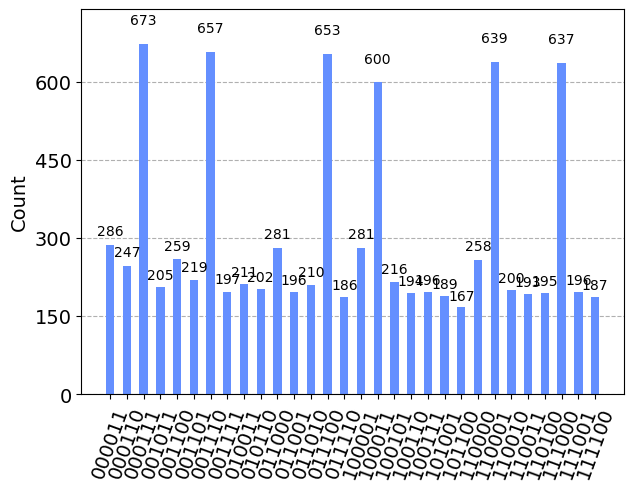

In [156]:
from qiskit.visualization import plot_histogram

# 输出结果
print("优化时间：", endTime - startTime)
print("Optimal parameters:", final_result.x)
print("Optimal value:", final_result.fun)
# 使用最优参数运行量子电路并输出测量结果
final_expectation, final_counts = cost_function(final_result.x, mixers_final)
sorted_dict = {item[0][::-1]: item[1] for item in sorted(final_counts.items(), key=lambda item: item[1], reverse=True)}
# 过滤掉计数小于 100 的结果
filtered_dict = {key: value for key, value in sorted_dict.items() if value >= 100}
print("Final expectation value:", final_expectation)
# print("Final measurement counts:", sorted_dict)
print("Final measurement counts (filtered):", filtered_dict)
# plot_histogram(sorted_dict)
print("mixers:", mixers_final)
# 绘制直方图
plot_histogram(filtered_dict)

<BarContainer object of 6 artists>

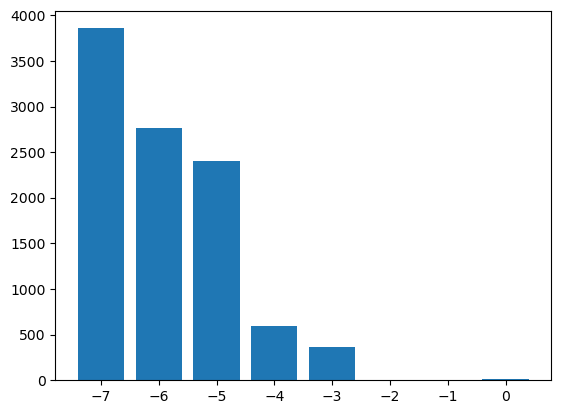

In [158]:
# 创建了一个默认值为 0 的字典 energies，用于存储每个最大割问题能量的计数
energies = defaultdict(int)
# 每个键 k 是一个表示测量结果的字符串，每个值 v 是该测量结果的计数
for k, v in counts.items():
    energies[maxcut_obj(k, G)] += v

# 将字典 energies 中的键值对分别提取出来，分别存储在 x 和 y 中。
# x 是能量值，y 是对应的计数
x, y = zip(*energies.items())
plt.bar(x, y)

Best string: 110001 with cut: 7


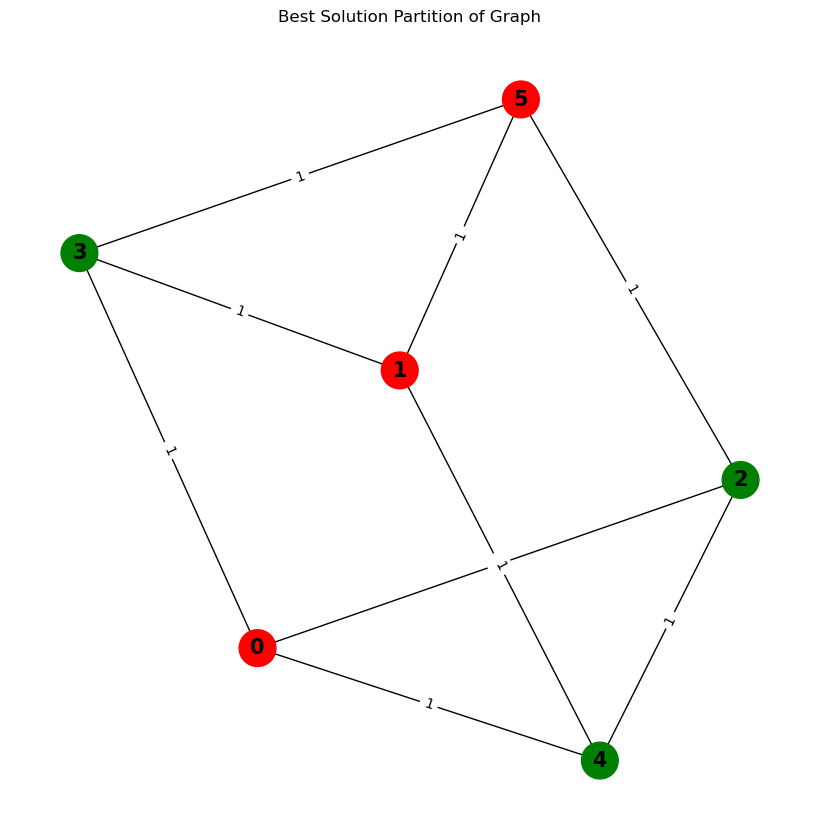

In [159]:
# 从 counts 字典中选择最佳解
best_cut, best_solution = min([(maxcut_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# 根据最佳解对节点进行着色
colors = ['r' if best_solution[i] == '0' else 'g' for i in range(n)]

# 绘制图，使用 spring_layout 或其他布局
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=colors, font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("Best Solution Partition of Graph")
plt.show()

In [160]:
# 计算期望值
expectation = 0
for bitstring, count in sorted_dict.items():
    bitstring = invert_counts(bitstring)
    prob = count / 10000
    E = maxcut_obj(bitstring, G)  #调用函数获得单个字符串能量值
    expectation += E * prob
print(expectation)

-5.9107


In [161]:
expectation = 0
bitstring = "001011"
E = maxcut_obj(bitstring, G)
print(E)

-5
